In [1]:
# Uncomment to upgrade packages
# !pip install pandas --upgrade --user --quiet
# !pip install numpy --upgrade --user --quiet
# !pip install scipy --upgrade --user --quiet
# !pip install statsmodels --upgrade --user --quiet
# !pip install scikit-learn --upgrade --user --quiet
# !pip install seaborn --upgrade --user --quiet
# !pip install imblearn --upgrade  --user

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.feature_selection import SelectKBest, f_regression, f_classif
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, roc_curve, auc, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# Load the preprocessed dataset
preprocessed_file_path = '../dataset_preprocessed.csv'
preprocessed_dataset = pd.read_csv(preprocessed_file_path)

# Display first few rows of the dataset
preprocessed_dataset.head()

,drg_segment,total_passengers_2022,total_passengers_2015,wifi_service,city_attraction_area,city_category_in_attraction_area_2020,department,region,sum_municipal_population_2021,non_scholarized_15_years_old_or_more_2020,...,passenger_growth_rate,attraction_density,city_size_category,Dubious,total_non_passengers_2022,total_non_passengers_2015,non_passenger_growth_rate,distance_to_paris,population_category,high_population
0,C,31539.0,29582.0,0,230,20,27,28,32349,25370,...,0.066155,0.000124,Small,No,0.0,0.0,0.0,120.798534,"(0, 300000]",Low
1,C,8398.0,10860.0,0,015,20,27,28,709065,504460,...,-0.226703,0.000133,Large,No,0.0,0.0,0.0,99.055375,"(600000, 900000]",High
2,C,909.0,1609.0,0,075,20,53,52,145065,104586,...,-0.435053,0.000241,Medium,No,0.0,0.0,0.0,239.876720,"(0, 300000]",Low
3,C,26956.0,11140.0,0,000,30,17,75,4444949,3492165,...,1.419749,0.001366,Tiny,No,0.0,0.0,0.0,449.310325,"(4200000, 4500000]",High
4,C,12724.0,12389.0,0,000,30,27,28,4444949,3492165,...,0.027040,0.001366,Tiny,No,0.0,0.0,0.0,116.221261,"(4200000, 4500000]",High


# Model Performance and Evaluation
This notebook evaluates Decision Tree, Random Forest, and Gradient Boosting models for both regression and classification tasks using a preprocessed dataset. Key metrics include Mean Squared Error (MSE) for regression and Accuracy for classification. Additionally, feature importance and ROC curves are analyzed.

In [4]:
# Define features and target for regression and classification tasks
features = preprocessed_dataset.drop(columns=['total_passengers_2022', 'wifi_service'])
target_regression = preprocessed_dataset['total_passengers_2022']
target_classification = preprocessed_dataset['wifi_service']

# Handle categorical features using one-hot encoding
categorical_cols = features.select_dtypes(include=['object']).columns
onehot_encoder = OneHotEncoder(sparse_output=False, drop='first')
onehot_encoded = onehot_encoder.fit_transform(features[categorical_cols])
onehot_encoded_df = pd.DataFrame(onehot_encoded, columns=onehot_encoder.get_feature_names_out(categorical_cols))

# Drop the original categorical columns and concatenate the one-hot encoded columns
features_encoded = features.drop(columns=categorical_cols).reset_index(drop=True)
features_encoded = pd.concat([features_encoded, onehot_encoded_df], axis=1)

# Split data into train and test sets
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(features_encoded, target_regression, test_size=0.2, random_state=42)
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(features_encoded, target_classification, test_size=0.2, random_state=42)

# Feature selection
select_k_best_reg = SelectKBest(score_func=f_regression, k=20)
select_k_best_clf = SelectKBest(score_func=f_classif, k=20)
X_train_reg_selected = select_k_best_reg.fit_transform(X_train_reg, y_train_reg)
X_test_reg_selected = select_k_best_reg.transform(X_test_reg)
X_train_clf_selected = select_k_best_clf.fit_transform(X_train_clf, y_train_clf)
X_test_clf_selected = select_k_best_clf.transform(X_test_clf)

/Users/pierrejezegou/Documents/FIB/fib-ml-project/.venv/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [113 117 128 150 162 173 184 200 203 215 237 238 239 258 265 274 288 289
 290 292 297 304 312 318 321 323 325 327 335 342 350 352 359 361 363 373
 383 384 389 392 393 401 408 413] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/pierrejezegou/Documents/FIB/fib-ml-project/.venv/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


## Feature Engineering and Data Splitting
Categorical features are one-hot encoded and feature selection is performed to select the top 20 features. The dataset is split into training and test sets for both regression and classification tasks.

In [5]:
# Function to evaluate and compare models
def evaluate_models(models, X_train, y_train, X_test, y_test, task_type='regression'):
    results = []
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        if task_type == 'regression':
            score = mean_squared_error(y_test, y_pred)
            results.append((name, score, y_pred, model))
        else:
            score = accuracy_score(y_test, y_pred)
            results.append((name, score, y_pred, model))
    return results

# Define models
models_regression = {
    'Decision Tree Regression': DecisionTreeRegressor(),
    'Random Forest Regression': RandomForestRegressor(),
    'Gradient Boosting Regression': GradientBoostingRegressor()
}

models_classification = {
    'Decision Tree Classification': DecisionTreeClassifier(),
    'Random Forest Classification': RandomForestClassifier(),
    'Gradient Boosting Classification': GradientBoostingClassifier()
}

## Model Evaluation
Three models are evaluated for both regression and classification tasks: Decision Tree, Random Forest, and Gradient Boosting.

In [6]:
# Evaluate models for regression
results_regression = evaluate_models(models_regression, X_train_reg_selected, y_train_reg, X_test_reg_selected, y_test_reg, task_type='regression')

# Evaluate models for classification
results_classification = evaluate_models(models_classification, X_train_clf_selected, y_train_clf, X_test_clf_selected, y_test_clf, task_type='classification')

# Hyperparameter Tuning

We use GridSearchCV to perform hyperparameter tuning on the Random Forest models to find the best parameters.

In [7]:
# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

# Random Forest Regression Grid Search
grid_search_rf_reg = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_rf_reg.fit(X_train_reg_selected, y_train_reg)
best_rf_reg = grid_search_rf_reg.best_estimator_
best_rf_reg_mse = mean_squared_error(y_test_reg, best_rf_reg.predict(X_test_reg_selected))

# Random Forest Classification Grid Search
grid_search_rf_clf = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search_rf_clf.fit(X_train_clf_selected, y_train_clf)
best_rf_clf = grid_search_rf_clf.best_estimator_
best_rf_clf_acc = accuracy_score(y_test_clf, best_rf_clf.predict(X_test_clf_selected))

# Results Summary

We summarize the performance of all models, including the tuned Random Forest models, and visualize the results.

In [8]:
# Summarize results
results_summary = pd.DataFrame({
    'Model': ['Decision Tree Regression', 'Random Forest Regression', 'Gradient Boosting Regression', 
              'Decision Tree Classification', 'Random Forest Classification', 'Gradient Boosting Classification', 
              'Tuned Random Forest Regression', 'Tuned Random Forest Classification'],
    'Metric': ['MSE', 'MSE', 'MSE', 'Accuracy', 'Accuracy', 'Accuracy', 'MSE', 'Accuracy'],
    'Score': [score for name, score, _, _ in results_regression] + [score for name, score, _, _ in results_classification] + [best_rf_reg_mse, best_rf_clf_acc]
})

# Display results
results_summary

,Model,Metric,Score
0,Decision Tree Regression,MSE,2.075451e+11
1,Random Forest Regression,MSE,1.074697e+11
2,Gradient Boosting Regression,MSE,1.189803e+11
3,Decision Tree Classification,Accuracy,9.686099e-01
4,Random Forest Classification,Accuracy,9.708520e-01
5,Gradient Boosting Classification,Accuracy,9.753363e-01
6,Tuned Random Forest Regression,MSE,1.016022e+11
7,Tuned Random Forest Classification,Accuracy,9.798206e-01


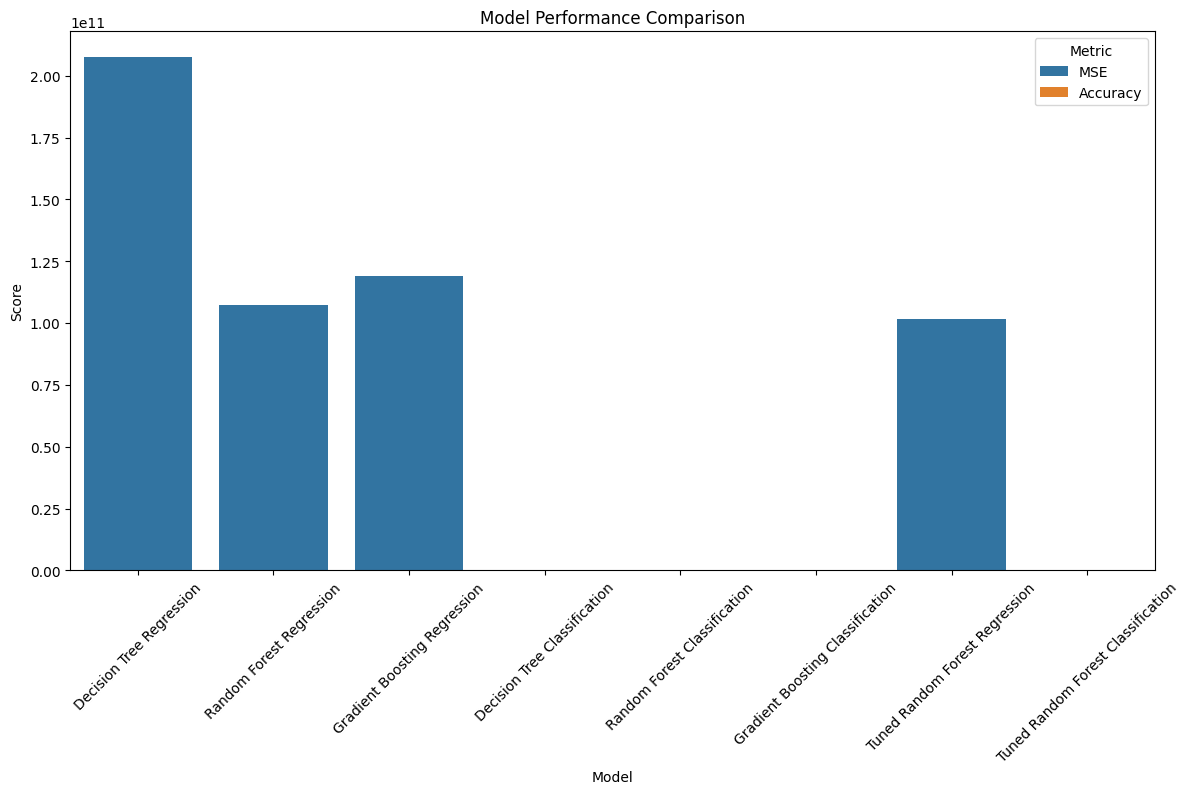

In [9]:
# Plot results for visual comparison
plt.figure(figsize=(14, 7))
sns.barplot(data=results_summary, x='Model', y='Score', hue='Metric')
plt.title('Model Performance Comparison')
plt.xticks(rotation=45)
plt.show()

# True vs Predicted Values for Regression

We visualize the true vs predicted values for each regression model to assess their performance.

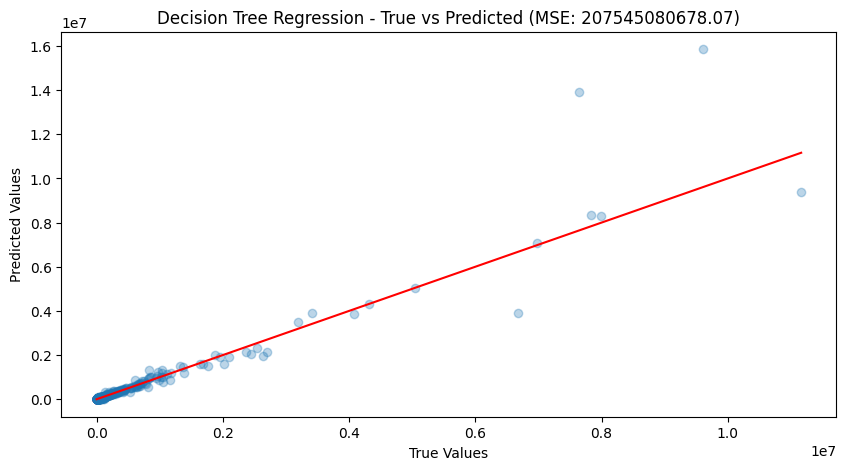

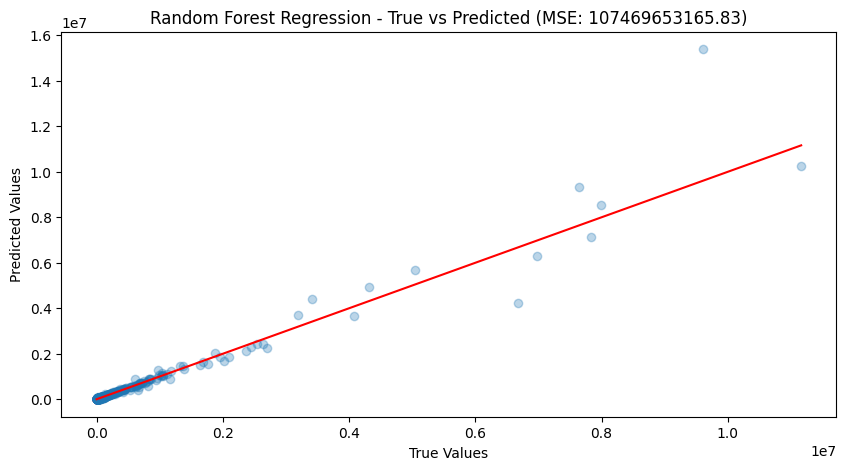

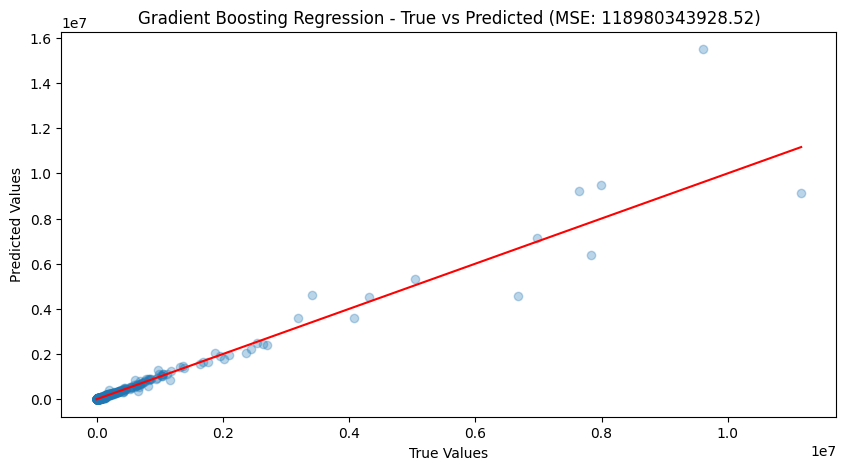

In [10]:
# Plot true vs predicted values for regression
for name, score, y_pred, model in results_regression:
    plt.figure(figsize=(10, 5))
    plt.scatter(y_test_reg, y_pred, alpha=0.3)
    plt.plot([min(y_test_reg), max(y_test_reg)], [min(y_test_reg), max(y_test_reg)], color='red')
    plt.title(f'{name} - True vs Predicted (MSE: {score:.2f})')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.show()


# Feature Importance for Regression Models

We plot the feature importances for each regression model to understand which features contributed most to the predictions.

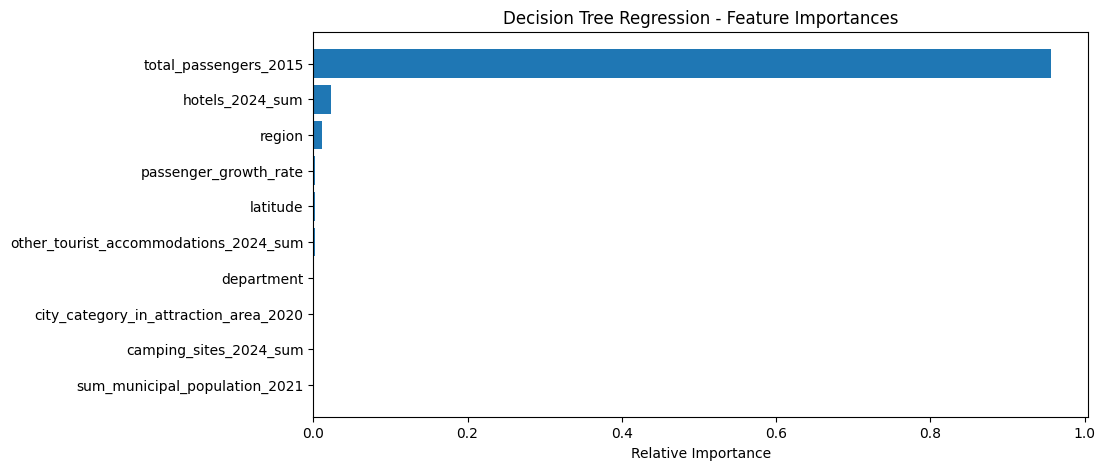

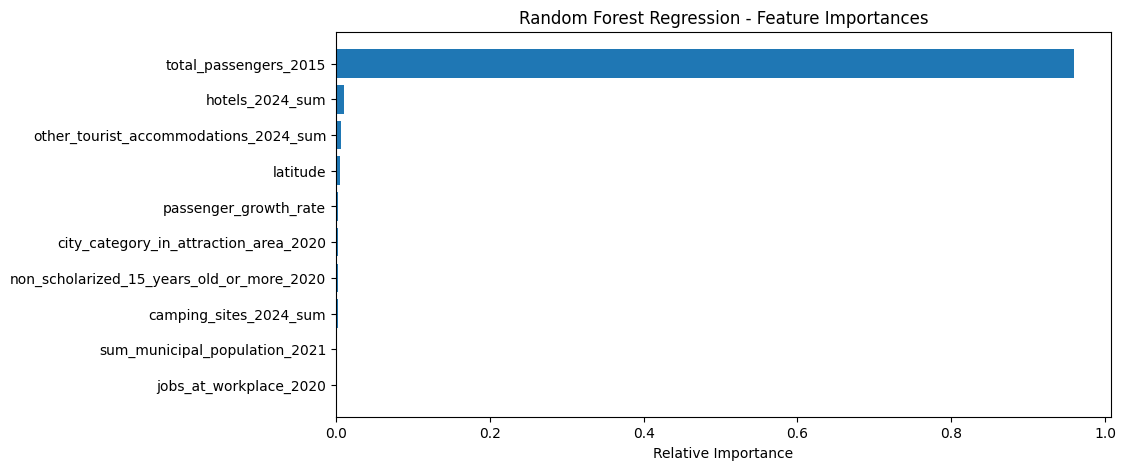

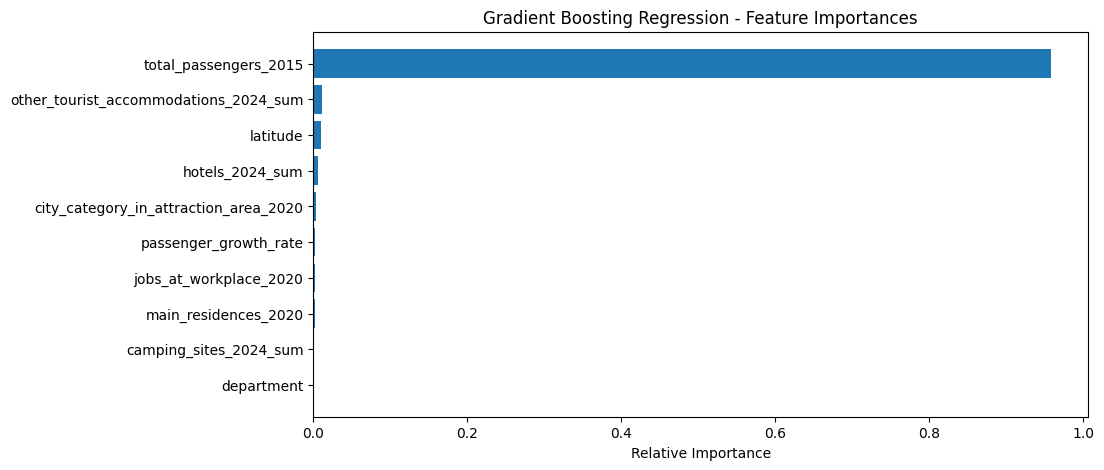

In [11]:
# Plot feature importances for regression models
for name, score, y_pred, model in results_regression:
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[-10:]  # Top 10 features
        plt.figure(figsize=(10, 5))
        plt.title(f'{name} - Feature Importances')
        plt.barh(range(len(indices)), importances[indices], align='center')
        plt.yticks(range(len(indices)), [features_encoded.columns[i] for i in indices])
        plt.xlabel('Relative Importance')
        plt.show()

# Confusion Matrices for Classification Models

We visualize the confusion matrices for each classification model to assess their performance.

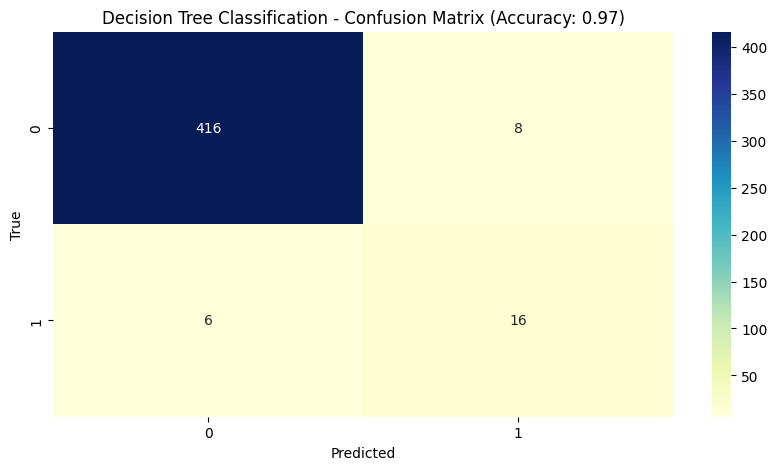

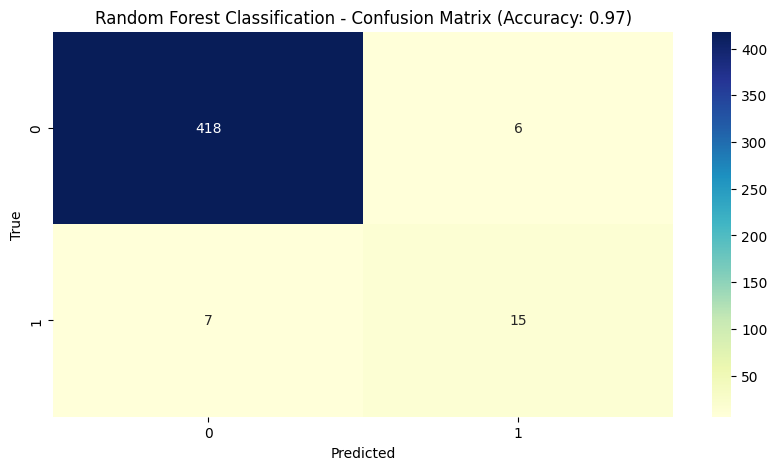

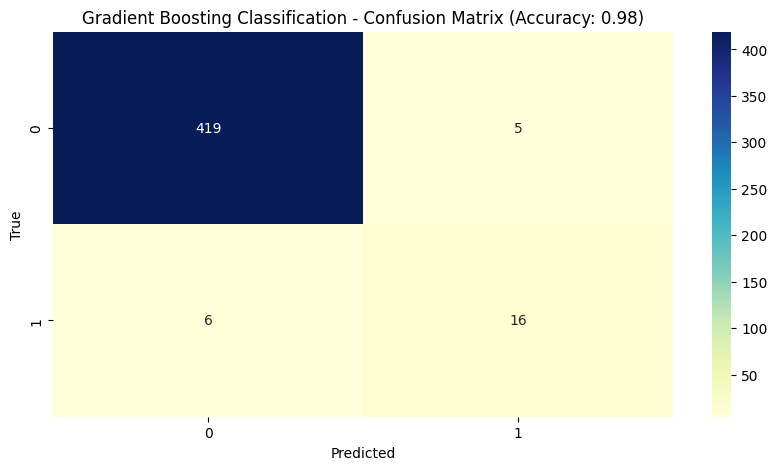

In [12]:
# Plot confusion matrix for classification
for name, score, y_pred, model in results_classification:
    plt.figure(figsize=(10, 5))
    sns.heatmap(pd.crosstab(y_test_clf, y_pred), annot=True, fmt="d", cmap="YlGnBu")
    plt.title(f'{name} - Confusion Matrix (Accuracy: {score:.2f})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Feature Importance for Classification Models

We plot the feature importances for each classification model to understand which features contributed most to the predictions.

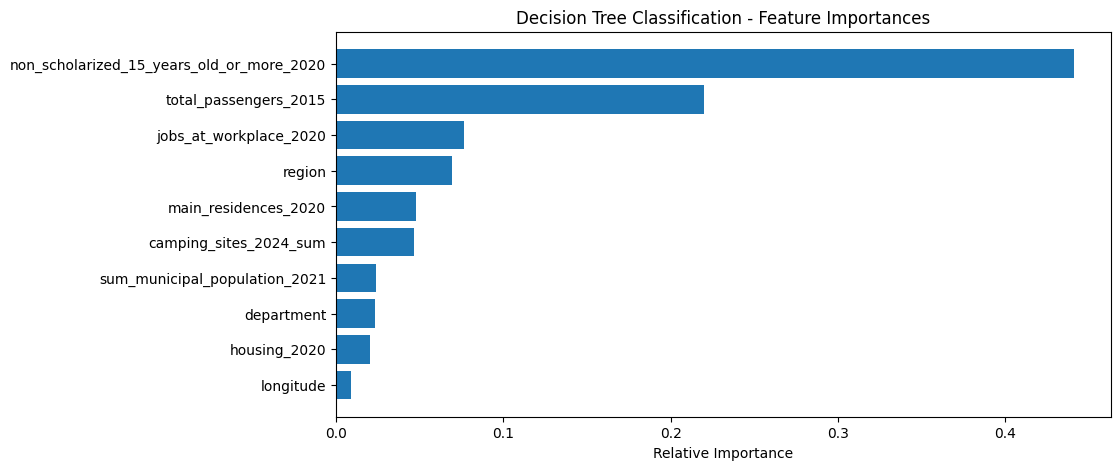

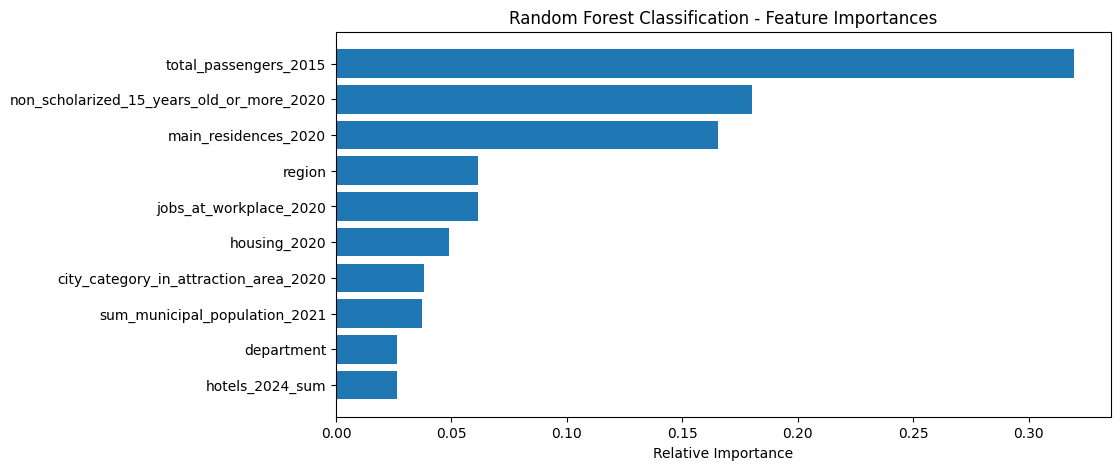

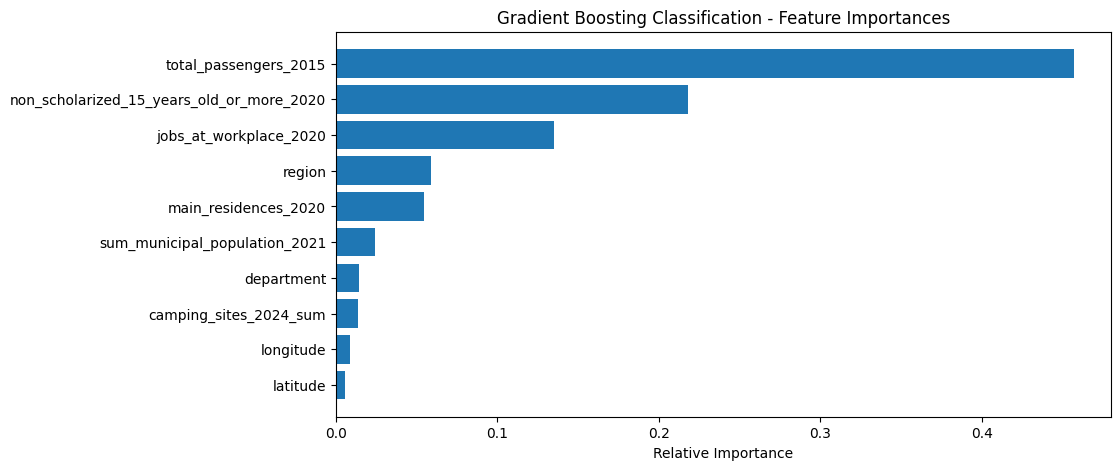

In [13]:
# Plot feature importances for classification models
for name, score, y_pred, model in results_classification:
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[-10:]  # Top 10 features
        plt.figure(figsize=(10, 5))
        plt.title(f'{name} - Feature Importances')
        plt.barh(range(len(indices)), importances[indices], align='center')
        plt.yticks(range(len(indices)), [features_encoded.columns[i] for i in indices])
        plt.xlabel('Relative Importance')
        plt.show()

# ROC Curves for Classification Models

We plot the ROC curves for each classification model to visualize their performance in terms of sensitivity and specificity.

<Figure size 1000x500 with 0 Axes>

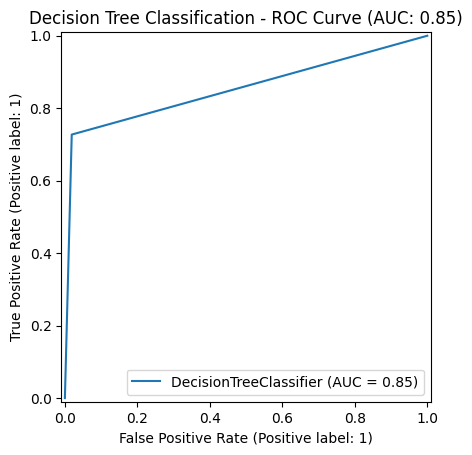

<Figure size 1000x500 with 0 Axes>

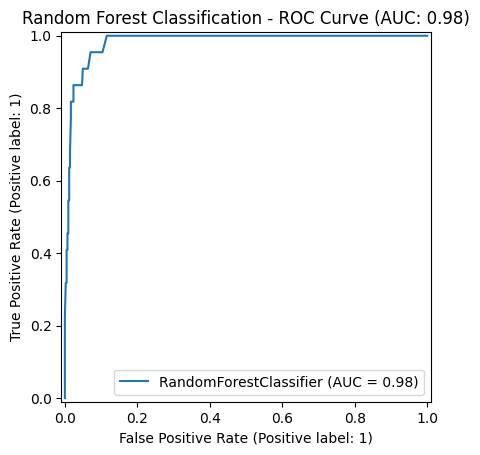

<Figure size 1000x500 with 0 Axes>

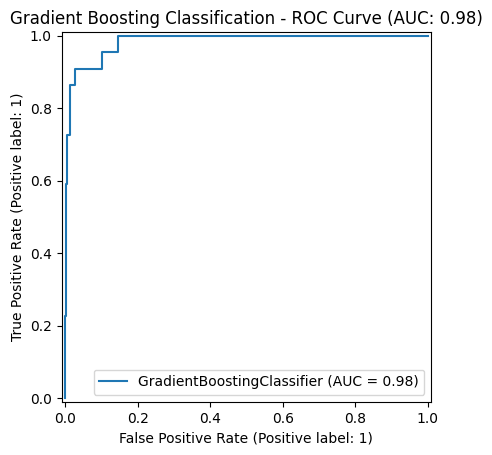

In [14]:
# Plot ROC curves for classification models
for name, score, y_pred, model in results_classification:
    if hasattr(model, 'predict_proba'):
        plt.figure(figsize=(10, 5))
        RocCurveDisplay.from_estimator(model, X_test_clf_selected, y_test_clf)
        plt.title(f'{name} - ROC Curve (AUC: {roc_auc_score(y_test_clf, model.predict_proba(X_test_clf_selected)[:,1]):.2f})')
        plt.show()